# Over Under Predictor

## Exploratory Data Analysis Notebook

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import seaborn as sns
import math
import re
%matplotlib inline
pd.set_option('display.max_columns', 100)

In [3]:
df = pd.read_csv('data/final_df.csv')

In [4]:
### Drop Columns not need for EDA ###
df = df.drop(columns=['stadium_address','stadium_weather_station_code',
                      'stadium_weather_type','STATION'])

df['over_under_result'] = np.where(df['over_under_result'] == 'Over',1,0)

df = df.dropna()

## Target Variable: Over/Under Result

To start the analysis it is important to look at the class imbalance of our Target Variable (Over/Under Result). The results below show a slight class imbalance with 'Under' Outcomes overrepresented by roughly 2%, or 141 observations. 

In [5]:
### Percentages of Classes ###
print("Total 'Under' Outcomes")
print(df.over_under_result.value_counts()[0])
print("Total 'Over' Outcomes")
print(df.over_under_result.value_counts()[1])
print('----------------------------------------')
print("Percent 'Under' Outcomes")
print(round((df.groupby(['over_under_result']).over_under_result.count()[0]/
       df.groupby(['over_under_result']).over_under_result.count().sum()),2))
print("Percent 'Over' Outcomes")
print(round((df.groupby(['over_under_result']).over_under_result.count()[1]/
       df.groupby(['over_under_result']).over_under_result.count().sum()),2))


Total 'Under' Outcomes
4978
Total 'Over' Outcomes
4837
----------------------------------------
Percent 'Under' Outcomes
0.51
Percent 'Over' Outcomes
0.49


The plot below titled "Total NFL Game Over/Unders" can help us visualize the class imbalance with our Target Variable. We can see that the imbalance is relatively small and not an immediate issue. 

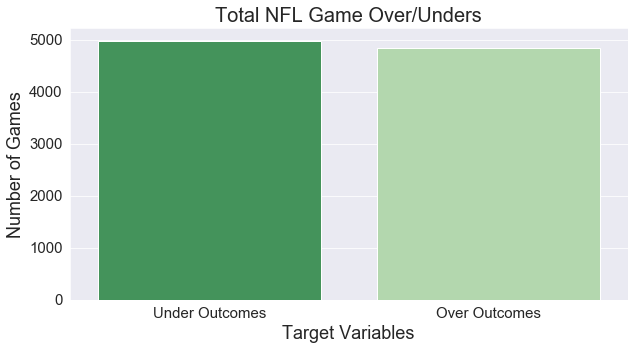

In [6]:
plt.figure(figsize = (10,5))
sns.set_style("darkgrid")
sns.countplot(df['over_under_result'], palette="Greens_r")
plt.title('Total NFL Game Over/Unders',fontsize = 20)
plt.ylabel('Number of Games',fontsize = 18)
plt.xlabel('Target Variables',fontsize = 18)
plt.yticks(fontsize = 15)
plt.xticks(np.arange(2), ['Under Outcomes','Over Outcomes'],fontsize = 15)
plt.show()

#### To start the EDA on the rest of the dataset I decided to break the features into four categories; Setting Data, Betting Data, Team Data, and Weather Data. 

# Setting Data EDA

To start we look at the Setting Data. These features consists of all features relating to the time and place that a given game was played.

### NFL Season

I decided to use seasons 1979 to 2020 in my analysis. First, I wanted to look at the how the Total Amount of Points scored in a game has changed over time. The Line Plot below shows that as time goes on there is an increase in Total Points. This could point to the "Over" being smarter bet going forward.

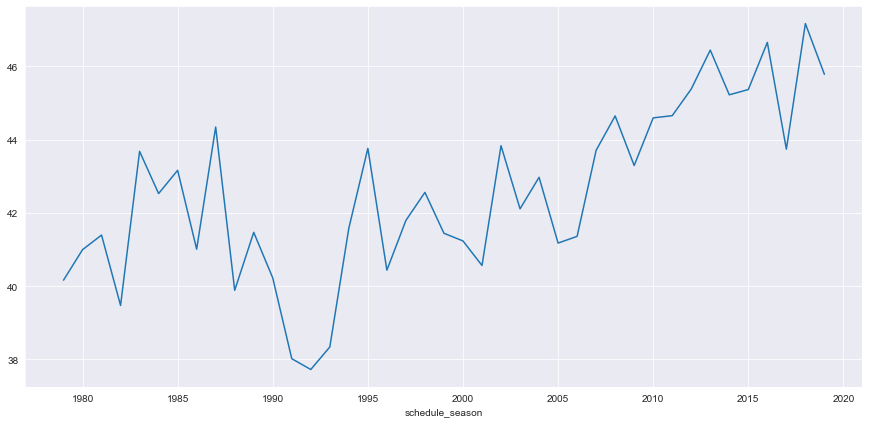

In [7]:
fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['schedule_season'])['total'].mean().plot(ax=ax)

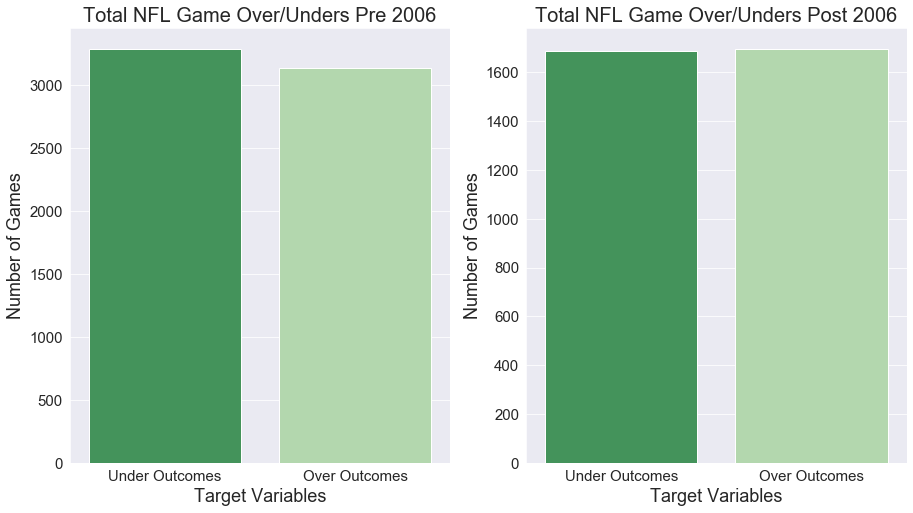

In [8]:
pre_2006_df = df[(df['schedule_season'] <= 2006)]
post_2006_df = df[(df['schedule_season'] > 2006)]

plt.figure(figsize = (15,8))
plt.subplot(1, 2, 1)
sns.set_style("darkgrid")
sns.countplot(pre_2006_df['over_under_result'], palette="Greens_r")
plt.title('Total NFL Game Over/Unders Pre 2006',fontsize = 20)
plt.ylabel('Number of Games',fontsize = 18)
plt.xlabel('Target Variables',fontsize = 18)
plt.yticks(fontsize = 15)
plt.xticks(np.arange(2), ['Under Outcomes','Over Outcomes'],fontsize = 15)

plt.subplot(1, 2, 2)
sns.set_style("darkgrid")
sns.countplot(post_2006_df['over_under_result'], palette="Greens_r")
plt.title('Total NFL Game Over/Unders Post 2006',fontsize = 20)
plt.ylabel('Number of Games',fontsize = 18)
plt.xlabel('Target Variables',fontsize = 18)
plt.yticks(fontsize = 15)
plt.xticks(np.arange(2), ['Under Outcomes','Over Outcomes'],fontsize = 15)
plt.show()

While it seems there might be a slight flip-flop after 2006, where the total points noticeably start increasing, it is not enough to be significant. 

### Schedule Week

Next I explored if the Day of the Week the game was played could possibily have an effect on the Over/Under Outcomes.

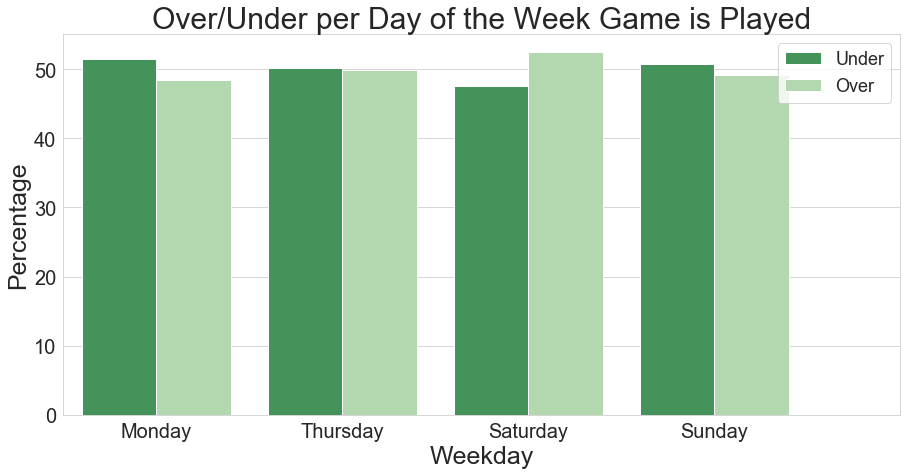

In [9]:
### Build Dataset that Groups by Week and Over Result, then get Percentage Over or Under ###
weekday_percent = (df.groupby(['weekday'])['over_under_result'].value_counts(normalize=True)
                     .rename('percentage').mul(100).reset_index().sort_values('over_under_result'))

### Get Rid of Monday and Tuesday because not enough games are played on those day ###
weekday_percent = weekday_percent[(weekday_percent.weekday != 1) & 
                                  (weekday_percent.weekday != 2) & 
                                  (weekday_percent.weekday != 4)]

### Plot ###
plt.figure(figsize = (15,7))
sns.set_style("whitegrid")
weekday_bar = sns.barplot(x="weekday", y="percentage", hue="over_under_result", data=weekday_percent, palette='Greens_r')
weekday_bar = plt.xticks(np.arange(5), ['Monday','Thursday','Saturday','Sunday'],fontsize=20)
weekday_bar = plt.yticks(fontsize=20)
weekday_bar = plt.xlabel('Weekday',fontsize=25)
weekday_bar = plt.ylabel('Percentage',fontsize=25)
weekday_bar = plt.title('Over/Under per Day of the Week Game is Played',fontsize = 30)
weekday_bar = plt.legend(fontsize=18)
weekday_bar.get_texts()[1].set_text('Over')
weekday_bar.get_texts()[0].set_text('Under')
plt.savefig('visualizations/weekday_bar.png')


It is interesting to see that on Monday and Saturday there seems to be a bigger disparity on Over/Under outcomes. To further investigate I will run an Anova test to determine if there is a significant difference in total points score between games played on a certain day

Null Hypothesis: The day of the week does not effect Total Points

Alternative Hypothesis: The day of the week does effect Total Points

In [10]:
import scipy.stats as stats

In [11]:
f_stats, p_value =stats.f_oneway(df[df['weekday'].eq(0)]['total'], 
               df[df['weekday'].eq(3)]['total'], 
               df[df['weekday'].eq(5)]['total'],
               df[df['weekday'].eq(6)]['total'],
                )

In [12]:
print(f'f-stat: {f_stats}, p_value: {p_value}')
print(f'We fail to reject the null hypothesis since our p_value is above 0.05')

f-stat: 2.489840157915511, p_value: 0.05841098815152604
We fail to reject the null hypothesis since our p_value is above 0.05


So while there is a slight disparity in Over/Under, it is not likely that we can determine a pattern depicting High Scoring or Low Scoring games. 

### Stadium Capacity

Next I started to look into how a stadium could effect the Over/Under outcome of an NFL game, starting with the size. The size of a stadium can actually be a big advantage in football. If there are more people in the stadium, the fans can generate more noise which makes it harder for players to communicate with each other. Thus, this will have the potential to effect the Over/Under Outcome. 

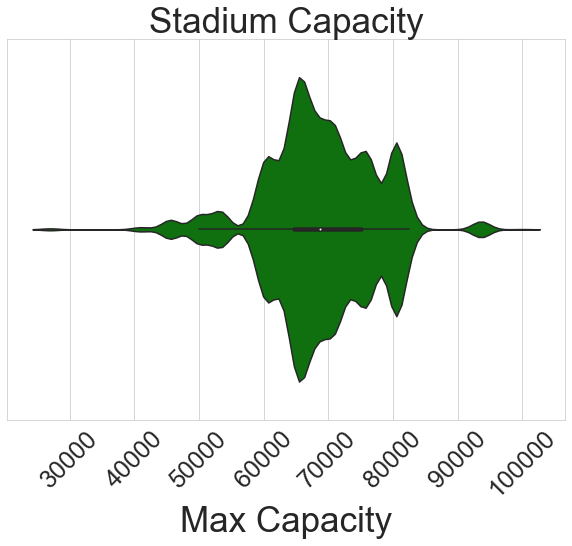

In [25]:
fig, ax = plt.subplots(figsize=(10,7))
sns.set_style("whitegrid")
capacity_violin = sns.violinplot(x=df["stadium_capacity"],color = 'green')
capacity_violin.set_title('Stadium Capacity',fontsize=35)
capacity_violin.set_xlabel('Max Capacity',fontsize=35)
plt.xticks(fontsize=25,rotation = 45)
plt.savefig('visualizations/capacity_violin.png')
plt.show()


To begin to get an understanding of the data the violin plot above gives us a good image to visualize the size most stadiums fall into. We see that most stadiums fall into the 60000 to 80000 range. 

In [26]:
# Group Stadium Sizes
stadium_groups=[]
for i in df['stadium_capacity']:
    if (i < 50000):
        stadium_groups.append(0)
    elif (i >= 50000) & (i <= 85000):
        stadium_groups.append(1)
    else:
        stadium_groups.append(2)
df['stadium_group'] = stadium_groups

In [27]:
### Build Dataset that Groups by Week and Over Result, then get Percentage Over or Under ###
stadium_percent = (df.groupby(['stadium_group'])['over_under_result'].value_counts(normalize=True)
                     .rename('percentage').mul(100).reset_index().sort_values('over_under_result'))

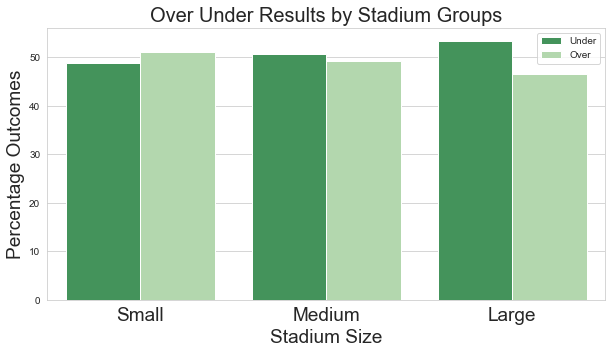

In [29]:
### Plot ###
plt.figure(figsize = (10,5))
sns.set_style("whitegrid")
stadium_bar = sns.barplot(x="stadium_group", y="percentage", hue="over_under_result", data=stadium_percent, palette='Greens_r')
stadium_bar = plt.xticks(np.arange(3), ['Small','Medium','Large'],fontsize=19)
stadium_bar = plt.xlabel('Stadium Size',fontsize=19)
stadium_bar = plt.ylabel('Percentage Outcomes',fontsize=19)
stadium_bar = plt.title('Over Under Results by Stadium Groups',fontsize = 20)
stadium_bar = plt.legend()
stadium_bar.get_texts()[1].set_text('Over')
stadium_bar.get_texts()[0].set_text('Under')
plt.savefig('visualizations/stadium_bar.png')


To get a better understanding I grouped stadiums into 3 seperate categories; Small, Medium, and Large. We see that in Large Stadiums the 'Under' outcome seems to be more prevalent. 

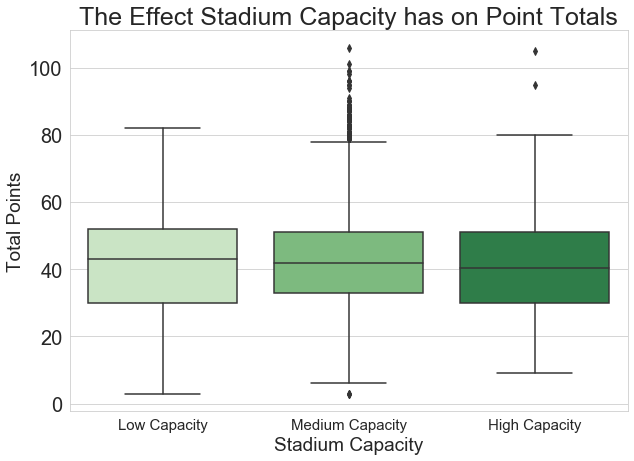

In [39]:
plt.figure(figsize = (10,7));
stadium_box = sns.boxplot(x = 'stadium_group', y = 'total', data = df, palette="Greens")
stadium_box.set_title('The Effect Stadium Capacity has on Point Totals',fontsize=25)
stadium_box.set_ylabel('Total Points',fontsize=19)
stadium_box.set_xlabel('Stadium Capacity',fontsize=19)
stadium_box.set_xticklabels(['Low Capacity','Medium Capacity','High Capacity'],fontsize=15)
stadium_box.tick_params(axis="y", labelsize=20)
plt.savefig('visualizations/stadium_totals.png')
plt.show()

After further analysis, we can see above that stadium capacity may have a very slight effect on point totals. Which could lead our bettor to bet on the Under outcome in Big Stadiums.

### Distance Traveled

Next I looked into the Distance Traveled by the Away Team. It is common in NFL betting lore that a long trip could negatively effect the traveling team. Below I started by looking at the frequency of trip length to determine the more common distances vs an abnormal trip.

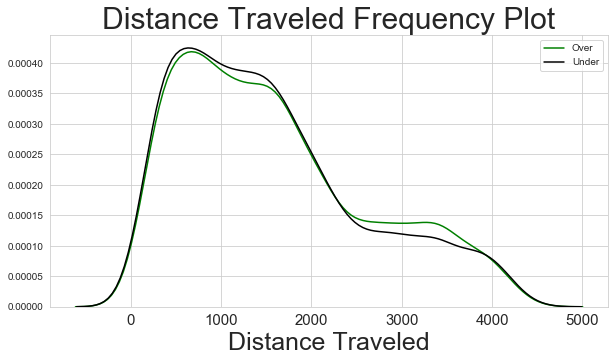

In [51]:
fig, ax = plt.subplots(figsize = (10,5));
pup = sns.distplot(df[df['over_under_result']== 1].dist_diff, color='Green',hist=False, label = 'Over')
pup = sns.distplot(df[df['over_under_result']== 0].dist_diff, color='Black',hist=False, label = 'Under')
pup.set_title('Distance Traveled Frequency Plot',fontsize=30)
pup.set_xlabel('Distance Traveled',fontsize=25)
pup.tick_params(axis="x", labelsize=15)
plt.savefig('visualizations/dist_traveled.png')
plt.show()

We can see that at around 1500 miles and under, and around 2500 miles and over, we start to see a disparity in the Over/Under Result. I will group the distanced traveled to see if there is a signification difference. 

In [52]:
# Group Distance Traveled For Away Team
trip_group=[]
for i in df['dist_diff']:
    if (i < 1000):
        trip_group.append(0)
    elif (i >= 1000) & (i <= 2700):
        trip_group.append(1)
    else:
        trip_group.append(2)
df['trip_group'] = trip_group

In [53]:
### Build Dataset that Groups by Week and Over Result, then get Percentage Over or Under ###
trip_percent = (df.groupby(['trip_group'])['over_under_result'].value_counts(normalize=True)
                     .rename('percentage').mul(100).reset_index().sort_values('over_under_result'))

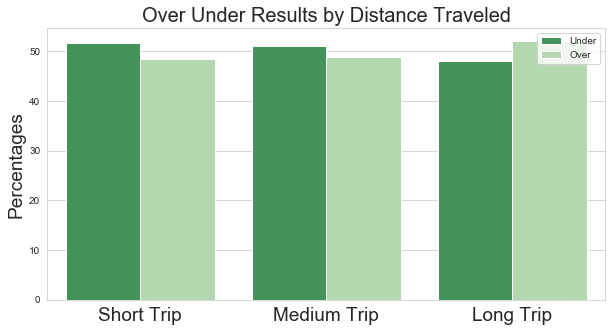

In [60]:
### Plot ###
plt.figure(figsize = (10,5))
sns.set_style("whitegrid")
trip_bar = sns.barplot(x="trip_group", y="percentage", hue="over_under_result", data=trip_percent, palette='Greens_r')
trip_bar = plt.xticks(np.arange(3), ['Short Trip','Medium Trip','Long Trip'],fontsize=19)
trip_bar = plt.xlabel('',fontsize=19)
trip_bar = plt.ylabel('Percentages',fontsize=19)
trip_bar = plt.title('Over Under Results by Distance Traveled',fontsize = 20)
trip_bar = plt.legend()
trip_bar.get_texts()[1].set_text('Over')
trip_bar.get_texts()[0].set_text('Under')
plt.savefig('visualizations/distance_bar.png')

We can see that there is evidence a short and medium size trip could potentially lead to an "Under" result. While a longer trip might lead to an "Over" result

# Betting Data EDA

Next I loved into some of the betting data that could help our bettor make more informed decisions. 

### Spread

The spread is a number set by a handicapper that predicts the difference in points between two teams.

In [62]:
spread_percent = (df.groupby(['spread_favorite'])['over_under_result'].value_counts(normalize=True)
                     .rename('percentage').mul(100).reset_index().sort_values('over_under_result'))

### Spread 17.5 and above sample too small ###
spread_percent = spread_percent[(spread_percent.spread_favorite < 16)]

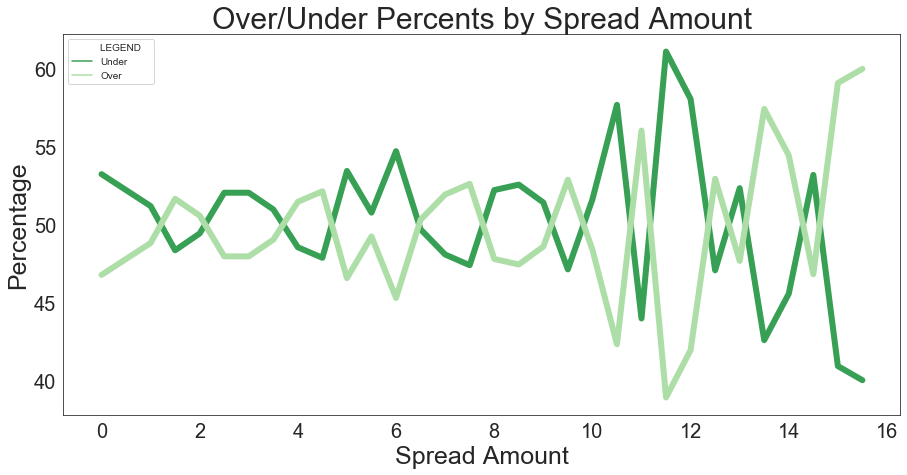

In [63]:
plt.figure(figsize = (15,7))
sns.set_style("white")
spread_line = sns.lineplot(x="spread_favorite", y="percentage", hue="over_under_result", 
                           data=spread_percent, palette='Greens_r',linewidth = 6)
spread_line = plt.title('Over/Under Percents by Spread Amount',fontsize = 30)
spread_line = plt.xticks(fontsize=20)
spread_line = plt.yticks(fontsize=20)
spread_line = plt.xlabel('Spread Amount',fontsize=25)
spread_line = plt.ylabel('Percentage',fontsize=25)
spread_line = plt.legend()
spread_legend = plt.legend()
spread_legend.get_texts()[2].set_text('Over')
spread_legend.get_texts()[1].set_text('Under')
spread_legend.get_texts()[0].set_text('LEGEND   ')
plt.savefig('visualizations/spread_plot.png')
### No Real Relationship, But as the number gets bigger the percentages start to increase ###


The plot above shows us that as the spread starts to increase, the percent Over or Under starts to become more volatile. While there is not an obvious pattern, coupled with another indicator could be the information our bettor can use to make a more knowledgeable decision. 

# Team Statistics Data EDA

### Team Previous Season Data

In [23]:
season_data = df.drop(columns=['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'team_home', 'score_home', 'score_away', 'team_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line',
       'stadium_neutral', 'total', 'over_under_result', 'stadium_name',
       'stadium_location', 'stadium_open', 'stadium_type', 'stadium_capacity',
       'stadium_surface', 'zipcode', 'weekday', 'zipcode_away', 'dist_diff',
       'home_W-L%', 'home_PD', 'home_MoV', 'home_SoS', 'home_SRS', 'home_OSRS',
       'home_DSRS', 'home_PF_per_game', 'home_PA_per_game', 'LATITUDE', 'LONGITUDE', 'unix', 'time',
       'summary', 'icon', 'precipIntensity', 'precipProbability', 'precipType',
       'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'pressure', 'windSpeed', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility', 'elevation', 'stadium_group', 'trip_group'] )

First, I assume that there will be a lot of multi-collinearity with out team statistics, so it is important to try to mitigate before we begin modeling

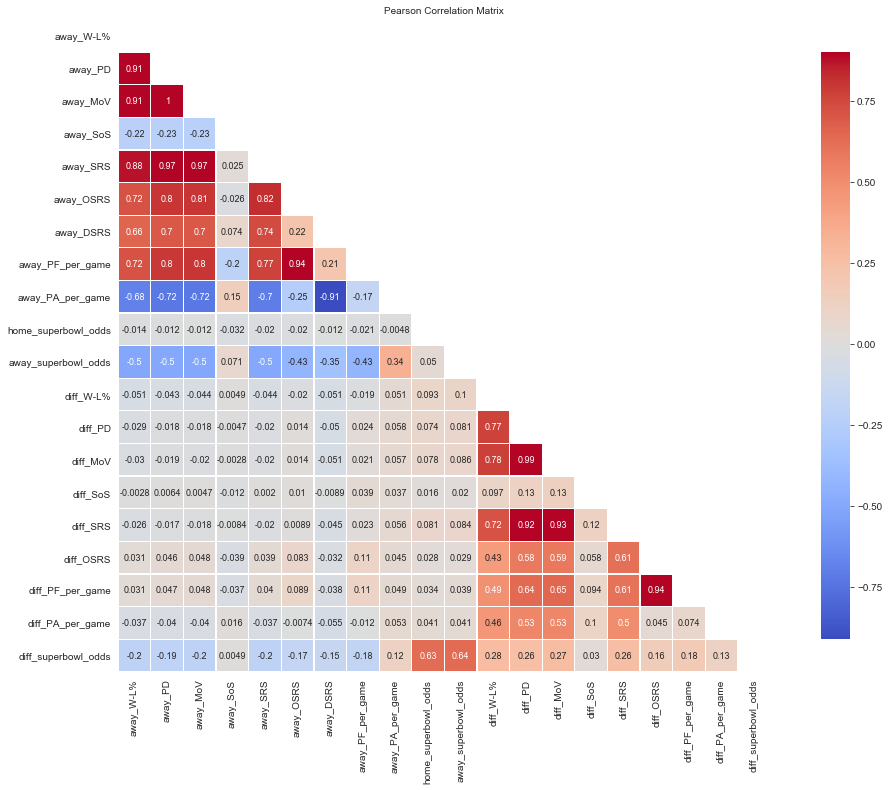

In [24]:
# Plot Correlation to Visualize Multi-Collinearity

mask = np.zeros_like(season_data.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(18, 12))
plt.title('Pearson Correlation Matrix',fontsize=10)

sns.heatmap(season_data.corr(),linewidths=0.25,vmax=0.9,square=True,cmap="coolwarm",
            linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});
plt.show()

It seems I will have to remove some features in preparation of Modeling. 

In [66]:
season_data = df.drop(columns=['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'team_home', 'score_home', 'score_away', 'team_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line',
       'stadium_neutral', 'total', 'over_under_result', 'stadium_name',
       'stadium_location', 'stadium_open', 'stadium_type', 'stadium_capacity',
       'stadium_surface', 'zipcode', 'weekday', 'zipcode_away', 'dist_diff',
       'home_W-L%', 'home_PD', 'home_MoV', 'home_SoS', 'home_SRS', 'home_OSRS',
       'home_DSRS', 'home_PF_per_game', 'home_PA_per_game', 'LATITUDE', 'LONGITUDE', 'unix', 'time',
       'summary', 'icon', 'precipIntensity', 'precipProbability', 'precipType',
       'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'pressure', 'windSpeed', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility', 'elevation', 'stadium_group', 'trip_group',
       'away_MoV','diff_MoV','diff_OSRS','away_SRS','diff_SRS','away_OSRS','away_PD', 'away_DSRS'] )

In [67]:
season_data.columns

Index(['away_W-L%', 'away_SoS', 'away_PF_per_game', 'away_PA_per_game',
       'home_superbowl_odds', 'away_superbowl_odds', 'diff_W-L%', 'diff_PD',
       'diff_SoS', 'diff_PF_per_game', 'diff_PA_per_game',
       'diff_superbowl_odds'],
      dtype='object')

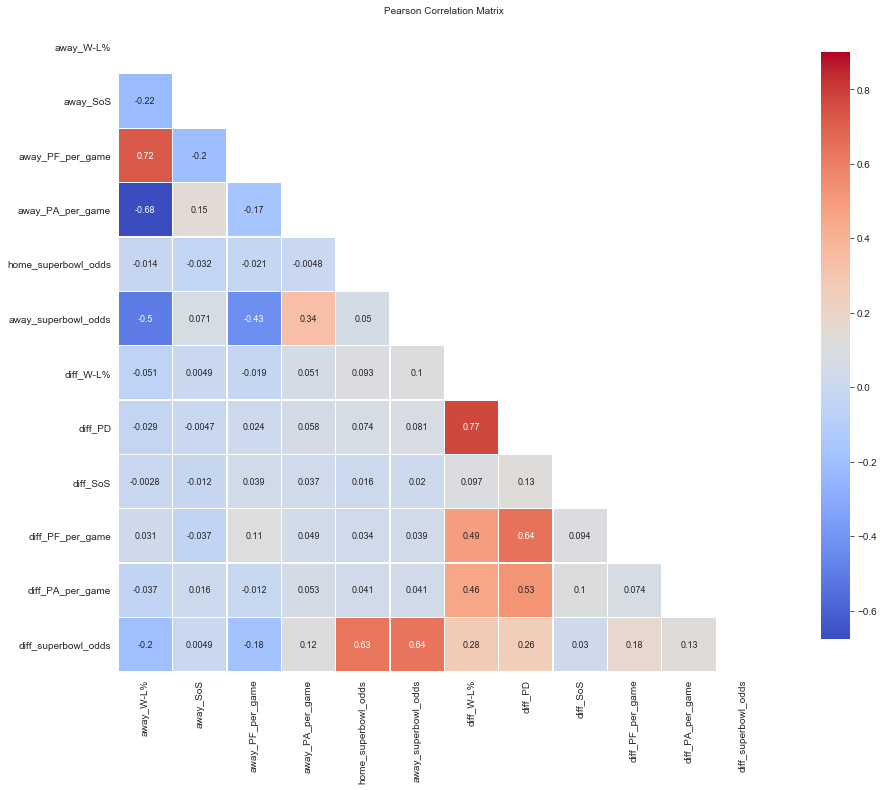

In [68]:
# Plot Correlation to Visualize Multi-Collinearity

mask = np.zeros_like(season_data.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(18, 12))
plt.title('Pearson Correlation Matrix',fontsize=10)

sns.heatmap(season_data.corr(),linewidths=0.25,vmax=0.9,square=True,cmap="coolwarm",
            linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});
plt.show()

After getting ride of all correlation scores above 0.77 my final Team Statistics will consist of 'W-L%', 'SoS', 'PF_per_game', 'PA_per_game','superbowl_odds','diff_W-L%', 'diff_PD', 'diff_SoS', 'diff_PF_per_game', 'diff_PA_per_game', 'diff_superbowl_odds'

In [69]:
df['home_win_loss'] = df['home_W-L%']
df['away_win_loss'] = df['away_W-L%']
df['diff_win_loss'] = df['diff_W-L%']

To start my analysis of the Team Statistics I will look at Win-Loss Percentage.

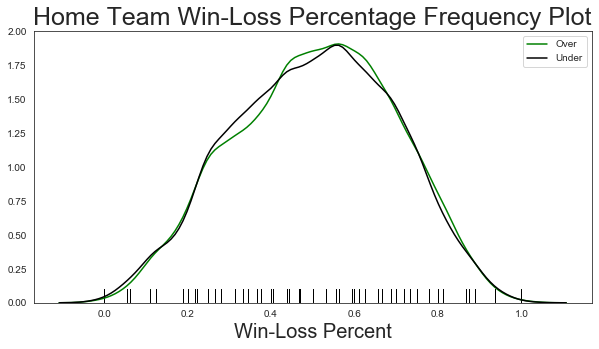

In [75]:
fig, ax = plt.subplots(figsize = (10,5));
sns.set_style('white')
home_freq = sns.distplot(df[df['over_under_result']== 1].home_win_loss, color='Green',hist=False, rug=True, label = 'Over')
home_freq = sns.distplot(df[df['over_under_result']== 0].home_win_loss, color='Black',hist=False, rug=True, label = 'Under')
home_freq.set_title('Home Team Win-Loss Percentage Frequency Plot',fontsize=25)
home_freq.set_xlabel('Win-Loss Percent',fontsize=20)
plt.savefig('visualizations/home_freq.png')


This frequency plot shows us that when the Home Team has a Win-Loss Percent at around 2% to 4% the Under has occured more frequently than the over. Then at 5% to 6.5% the over is more common.

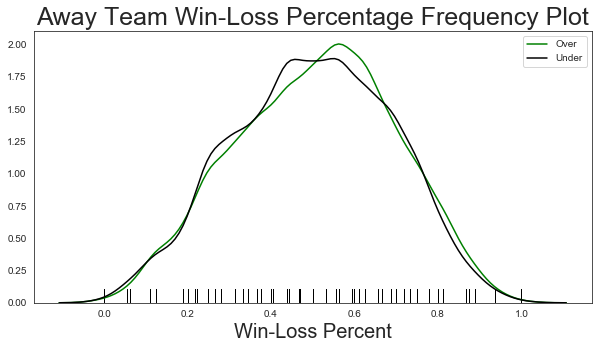

In [79]:
fig, ax = plt.subplots(figsize = (10,5));
sns.set_style('white')
away_freq = sns.distplot(df[df['over_under_result']== 1].away_win_loss, color='Green',hist=False, rug=True, label = 'Over')
away_freq = sns.distplot(df[df['over_under_result']== 0].away_win_loss, color='Black',hist=False, rug=True, label = 'Under')
away_freq.set_title('Away Team Win-Loss Percentage Frequency Plot',fontsize=25)
away_freq.set_xlabel('Win-Loss Percent',fontsize=20)
plt.savefig('visualizations/away_freq.png')


Then when looking at the Away Team we see that when the Win-Loss Percentage is around 6% the Over occurs more frequently.

This could possibly be an indicator that when either team has a Win-Loss Percent around 6% it can be more beneficial to bet on the Over. 

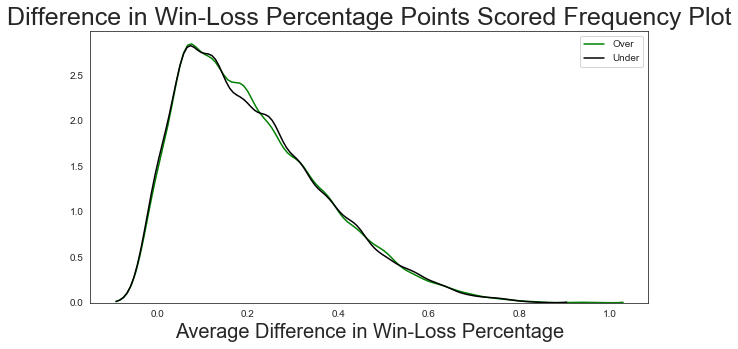

In [80]:
fig, ax = plt.subplots(figsize = (10,5));
sns.set_style('white')
away_freq = sns.distplot(df[df['over_under_result']== 1].diff_win_loss, color='Green',hist=False, label = 'Over')
away_freq = sns.distplot(df[df['over_under_result']== 0].diff_win_loss, color='Black',hist=False, label = 'Under')
away_freq.set_title('Difference in Win-Loss Percentage Points Scored Frequency Plot',fontsize=25)
away_freq.set_xlabel('Average Difference in Win-Loss Percentage',fontsize=20)
plt.savefig('visualizations/diff_team_freq.png')

We see when looking at the difference between Away and Home team Win-Loss Percent there is a very brief window at roughly 2% where the Over occurs more frequently than the Under.

In [32]:
test_df = df.loc[(df['away_win_loss']>.5) & (df['away_win_loss']<.7) ]
test_df = test_df.loc[(test_df['diff_win_loss']>.175) & (test_df['diff_win_loss']<.215)]

print("Percent 'Under' Outcomes")
print(round((test_df.groupby(['over_under_result']).over_under_result.count()[0]/
       test_df.groupby(['over_under_result']).over_under_result.count().sum()),2))
print("Percent 'Over' Outcomes")
print(round((test_df.groupby(['over_under_result']).over_under_result.count()[1]/
       test_df.groupby(['over_under_result']).over_under_result.count().sum()),2))


Percent 'Under' Outcomes
0.47
Percent 'Over' Outcomes
0.53


We can see a 6% increase in likelihood that an Over will occur when the difference in Win-Loss Percentage is between .174 and .215, and the Away Team Win-Loss Percentage is between .5 and .7. This could be something to look out for while placing a bet. 

# Weather Data EDA

Last, I looked to see if the Weather that occured during the game could help bring us any data insights

In [33]:
weather_df = df.drop(columns = ['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'team_home', 'score_home', 'score_away', 'team_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line',
       'stadium_neutral', 'total', 'over_under_result', 'stadium_name',
       'stadium_location', 'stadium_open', 'stadium_type',
       'stadium_capacity', 'stadium_surface','stadium_group',
       'zipcode', 'weekday', 'zipcode_away', 'dist_diff', 'home_W-L%',
       'home_PD', 'home_MoV', 'home_SoS', 'home_SRS', 'home_OSRS', 'home_DSRS',
       'home_PF_per_game', 'home_PA_per_game', 'away_W-L%', 'away_PD',
       'away_MoV', 'away_SoS', 'away_SRS', 'away_OSRS', 'away_DSRS',
       'away_PF_per_game', 'away_PA_per_game', 'home_superbowl_odds',
       'away_superbowl_odds', 'diff_W-L%', 'diff_PD', 'diff_MoV', 'diff_SoS',
       'diff_SRS', 'diff_OSRS', 'diff_PF_per_game', 'diff_PA_per_game',
       'diff_superbowl_odds', 'LATITUDE', 'LONGITUDE', 'unix', 'time','diff_win_loss','away_win_loss','home_win_loss'])

### Weather Correlation

Similar to the team statistics, it is important for us to look for any redundant features leading to multi-collinearity

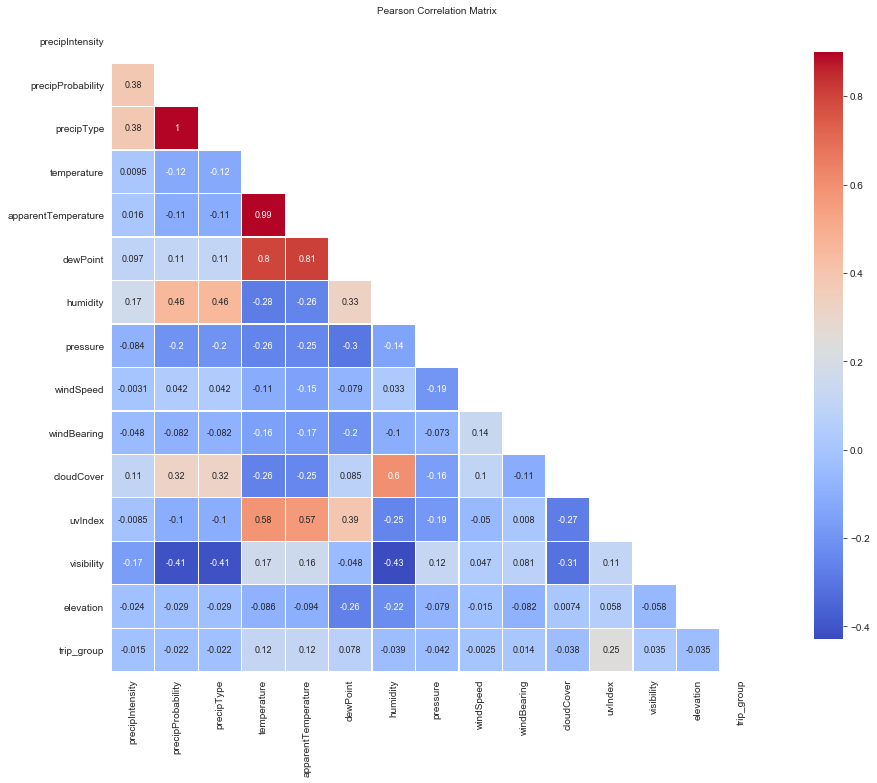

In [34]:
mask = np.zeros_like(weather_df.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(18, 12))
plt.title('Pearson Correlation Matrix',fontsize=10)

sns.heatmap(weather_df.corr(),linewidths=0.25,vmax=0.9,square=True,cmap="coolwarm",
            linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});
plt.show()

In [35]:
weather_df = weather_df.drop(columns = ['precipProbability','apparentTemperature'])

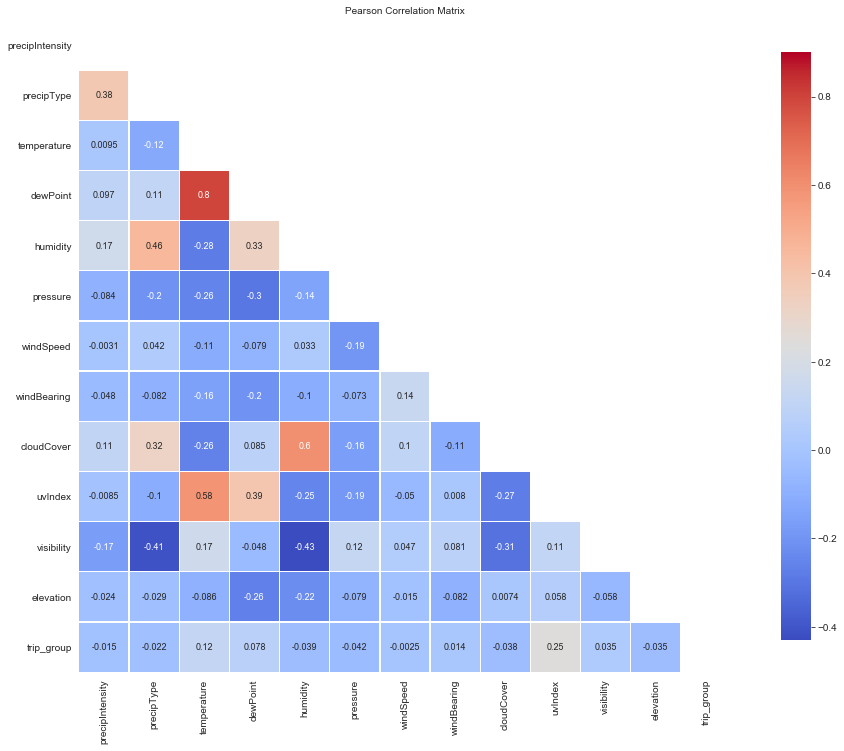

In [36]:
mask = np.zeros_like(weather_df.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(18, 12))
plt.title('Pearson Correlation Matrix',fontsize=10)

sns.heatmap(weather_df.corr(),linewidths=0.25,vmax=0.9,square=True,cmap="coolwarm",
            linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});
plt.show()

dropped 'precipProbability' and 'apparentTemperature'because they were too similar to 'precipType' and 'tempurature respectivley. Decided to leave 'dewpoint' because I believe it is independent enough from 'tempurature'

### Wind Mile per Hour

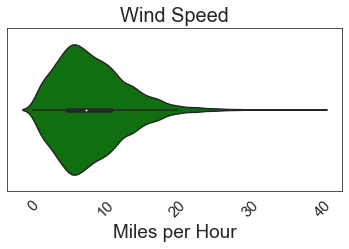

In [82]:
fig, ax = plt.subplots(figsize=(6,3))
sns.set_style("whitegrid")
wind_violin = sns.violinplot(x=df["windSpeed"],color = 'green')
wind_violin.set_title('Wind Speed',fontsize=20)
wind_violin.set_xlabel('Miles per Hour',fontsize=19)
plt.xticks(fontsize=15,rotation = 45)
plt.show()

Above we have a violin plot that will give us some insight into the frequency of Wind Speed. We see that Wind Speeds over 20mph are not very common

In [83]:
df['windSpeed'] = df['windSpeed'].apply(np.floor)
wind_percent = (df.groupby(['windSpeed'])['over_under_result'].value_counts(normalize=True)
                     .rename('percentage').mul(100).reset_index().sort_values('over_under_result'))
wind_zeros = pd.DataFrame([[34.0, 1,0], [33.0, 1,0], [28.0, 1,0], [39.0, 0,0]], columns=['windSpeed','over_under_result','percentage'])
wind_percent = wind_percent.append(wind_zeros)


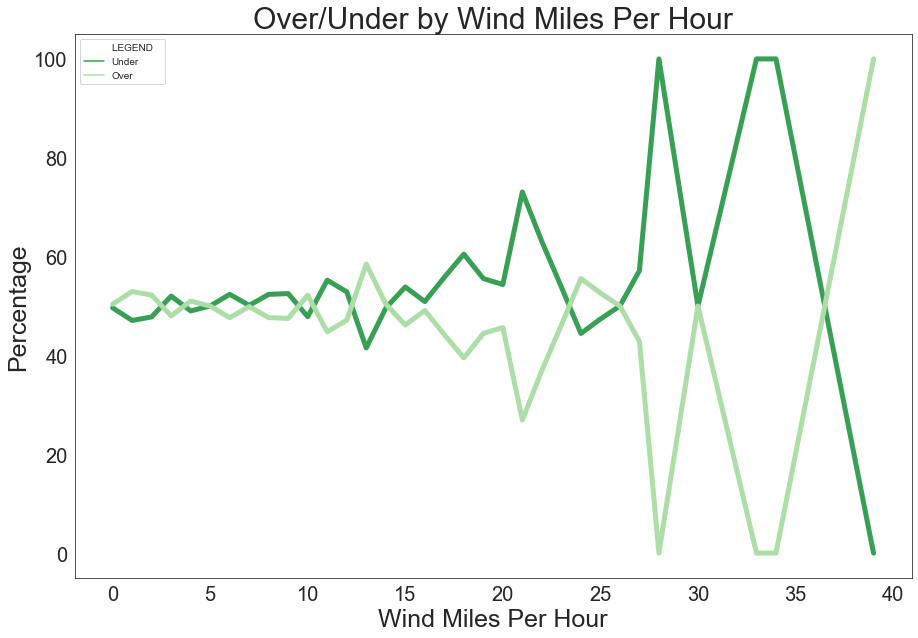

In [84]:
plt.figure(figsize = (15,10))
sns.set_style("white")
wind_plot = sns.lineplot(x="windSpeed", y="percentage", hue="over_under_result", 
                         data=wind_percent, palette='Greens_r',linewidth = 5)
wind_plot = plt.title('Over/Under by Wind Miles Per Hour',fontsize = 30)
wind_plot = plt.xticks(fontsize=20)
wind_plot = plt.yticks(fontsize=20)
wind_plot = plt.xlabel('Wind Miles Per Hour',fontsize=25)
wind_plot = plt.ylabel('Percentage',fontsize=25)
wind_plot = plt.legend()
wind_legend = plt.legend()
wind_legend.get_texts()[2].set_text('Over')
wind_legend.get_texts()[1].set_text('Under')
wind_legend.get_texts()[0].set_text('LEGEND   ')
plt.savefig('visualizations/wind_plot.png')



Here we see the percentage of Overs and Unders as the Wind Speeds get higher. It seems that as the winds increase the likelihood of an 'Under' is more likely. This is the type of knowledge thst could help a bettor make an more informed decision.

In [85]:
wind_groups=[]
for i in df['windSpeed']:
    if (i < 15):
        wind_groups.append(0)
    else:
        wind_groups.append(1)
df['wind_group'] = wind_groups

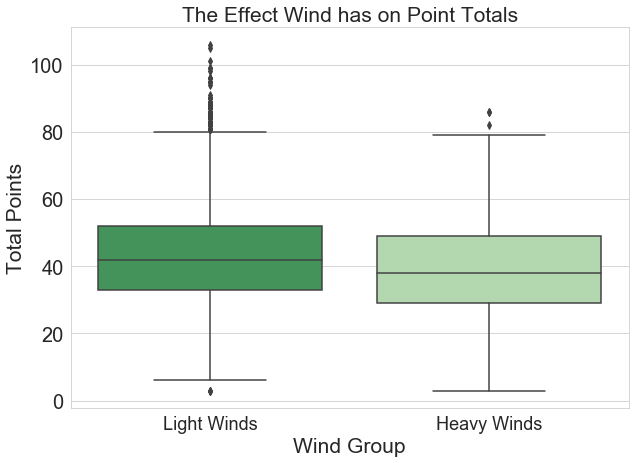

In [89]:
plt.figure(figsize = (10,7));

wind_box = sns.boxplot(x = 'wind_group', y = 'total',data = df, palette="Greens_r")
sns.set_style("whitegrid")
wind_box.set_title('The Effect Wind has on Point Totals',fontsize=21)
plt.yticks(fontsize=20)
wind_box.set_ylabel('Total Points',fontsize=21)
wind_box.set_xlabel('Wind Group',fontsize=21)
wind_box.set_xticklabels(['Light Winds','Heavy Winds'],fontsize=18)
plt.savefig('visualizations/wind_box.png')
plt.show()

To help confirm our suspicion, we can see above that as the winds get heavier, the point totals begin to drop.

### Temperature 

In [42]:
round_temps = []
for temp in df.temperature:
    round_temps.append(round(temp))

df['round_temps'] = round_temps

In [43]:
temp_percent = (df.groupby(['round_temps'])['over_under_result'].value_counts(normalize=True)
                     .rename('percentage').mul(100).reset_index().sort_values('over_under_result'))
temp_zeros = pd.DataFrame([[6, 0,0], [-1, 0,0], [-4, 0,0], [-9, 1,0],[-3, 1,0], [3, 1,0],[108, 1,0]], 
                          columns=['round_temps','over_under_result','percentage'])
temp_percent = temp_percent.append(temp_zeros)

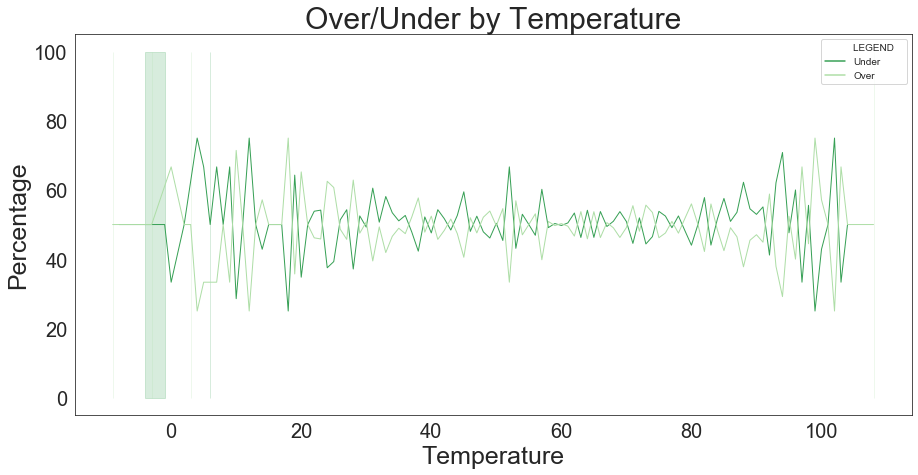

In [44]:
plt.figure(figsize = (15,7))
sns.set_style("white")
temp_plot = sns.lineplot(x="round_temps", y="percentage", hue="over_under_result", 
                         data=temp_percent, palette='Greens_r',linewidth = 1)
temp_plot = plt.title('Over/Under by Temperature',fontsize = 30)
temp_plot = plt.xticks(fontsize=20)
temp_plot = plt.yticks(fontsize=20)
temp_plot = plt.xlabel('Temperature',fontsize=25)
temp_plot = plt.ylabel('Percentage',fontsize=25)
temp_plot = plt.legend()
temp_legend = plt.legend()
temp_legend.get_texts()[2].set_text('Over')
temp_legend.get_texts()[1].set_text('Under')
temp_legend.get_texts()[0].set_text('LEGEND   ')
#plt.savefig('temp_plot.png')

This plot shows similar to winds, when the temperature becomes more extreme there is much more disparity between 'Over' and 'Under' outcomes. When the outcome is more disperse we could potentially use our data insights to guide the bettor to a potential winning pick

In [45]:
temp_groups=[]
for i in df['temperature']:
    if (i < 20):
        temp_groups.append(0)
    elif (i > 85):
        temp_groups.append(2)
    else:
        temp_groups.append(1)
df['temp_group'] = temp_groups

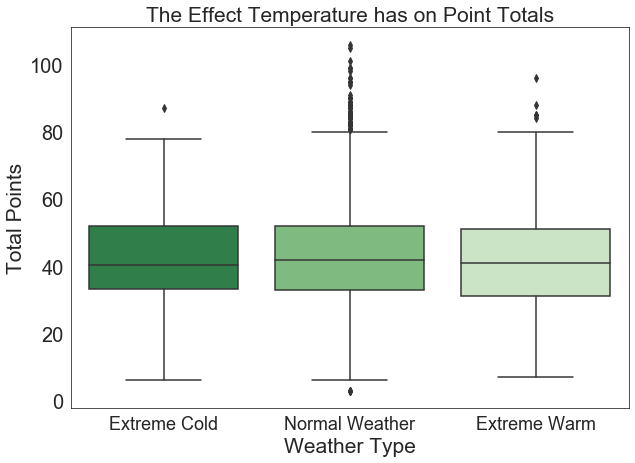

In [46]:
plt.figure(figsize = (10,7));

wind_box = sns.boxplot(x = 'temp_group', y = 'total',data = df, palette="Greens_r")
sns.set_style("whitegrid")
wind_box.set_title('The Effect Temperature has on Point Totals',fontsize=21)
plt.yticks(fontsize=20)
wind_box.set_ylabel('Total Points',fontsize=21)
wind_box.set_xlabel('Weather Type',fontsize=21)
wind_box.set_xticklabels(['Extreme Cold','Normal Weather','Extreme Warm'],fontsize=18)
plt.savefig('temp_box.png')
plt.show()

We see here that while there might be a slight difference in the average of total points between Extreme Weather and Normal Weather, it is not significant enough to bet on. 